# SVM Model for each animal

Goal here to assess the performance of the classifier for each animal.
For each animal, split train and test data (external cross validation).
In the training data, make a second cross-val (internal cross-val, train-validation) to optimize the hyperparameters.
Decide the model at the end of this cross-val with the best-performing average AUC

Train the model on the outer cross-val training set
Test it on the test set.
This will give n models with n performances

In [1]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [2]:
"""Set all global parameters to be monitored"""

n_splits_o = 5
n_splits_i = 4
animal_ID = 12
factor_red = 100

# To reduce the computational expense and the number of features to try in PCA during Hyperparameter optimization
nb_feats_min = 70
nb_feats_max = 110

In [3]:
"""Set sthe animal ID"""

animal_ID = animal_ID
animal_names = {1: "fKH41", 2: "fKH42", 3: "fKH43", 4: "fKH47", 5: "fKH50", 6: "fKH51", 7: "fKH52", 8: "fKH54", 9: "fKH56", 10: "fKH57", 11: "fKH58", 12: "fKH33"}


In [4]:
"""Load the dataset and set randomness."""
# (from Emma's code)

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
data = spio.loadmat("features_10s_2019-01-30.mat");
features = data['features'];
labels = data['labels_features'];
animal_id_features = data['animal_id_features'];

# Flatten animal IDs so we can slice by animal.
id_features = np.ravel(animal_id_features);

# Indexes animal of interest.
indexes = np.where(id_features == animal_ID)
indexes = np.ravel(indexes)

# Get only features corresponding to animal selected.
animal_features = np.array([features[index, :] for index in indexes])
labels = labels.transpose()
animal_labels = np.array([labels[index] for index in indexes]);


In [5]:
print(animal_features)
print(indexes)

[[4.33660382e-02 3.01954463e-02 3.10574709e-02 ... 1.10000000e+01
  1.20000000e+01 1.00000000e+00]
 [4.21477161e-02 3.10248619e-02 3.14682171e-02 ... 2.50000000e+01
  3.80000000e+01 4.50000000e+01]
 [4.22937034e-02 2.88042523e-02 2.85215292e-02 ... 5.00000000e+00
  2.00000000e+01 6.00000000e+00]
 ...
 [6.17070020e-02 4.28467959e-02 4.43389758e-02 ... 1.50000000e+01
  1.00000000e+00 5.00000000e+00]
 [6.74262637e-02 5.46452433e-02 5.55657835e-02 ... 2.00000000e+01
  1.20000000e+01 1.60000000e+01]
 [7.38921517e-02 5.81516910e-02 5.99666968e-02 ... 1.10000000e+01
  2.80000000e+01 1.60000000e+01]]
[529448 529449 529450 ... 586194 586195 586196]


In [6]:
"""Reduce the number of classes: delete the seizures - Prediction model"""

a = np.where(animal_labels == 2)

animal_labels_tmp = np.delete(animal_labels, a)
animal_features_tmp = np.delete(animal_features, a, 0);
animal_labels = animal_labels_tmp
animal_features = animal_features_tmp

print(animal_labels.shape)
print(animal_features.shape)

(56511,)
(56511, 141)


In [7]:
"""Reducing the size of the vectors for easier computation"""
factor = factor_red

"""Shuffling the data to train/test on smaller subsets"""
shuffled_animal_features = np.empty(animal_features.shape, dtype=animal_features.dtype)
shuffled_animal_labels = np.empty(animal_labels.shape, dtype=animal_labels.dtype)
permutation = np.random.permutation(len(animal_labels))
for old_index, new_index in enumerate(permutation):
        shuffled_animal_features [new_index] = animal_features[old_index]
        shuffled_animal_labels[new_index] = animal_labels[old_index]
animal_features = shuffled_animal_features
animal_labels = shuffled_animal_labels

animal_features = animal_features[0:int(len(animal_features)/factor),:]
animal_labels = animal_labels[0:np.int(len(animal_labels)/factor)]

In [8]:
print(animal_labels.shape)
print(animal_features.shape)

(565,)
(565, 141)


## Cross validation whole loop

Process ended, outer fold  0 , inner fold  0
Process ended, outer fold  0 , inner fold  1
Process ended, outer fold  0 , inner fold  2
Process ended, outer fold  0 , inner fold  3
[[0.65757725 0.34242275]
 [0.48272771 0.51727229]
 [0.35370628 0.64629372]
 [0.45443651 0.54556349]
 [0.40489101 0.59510899]
 [0.66209679 0.33790321]
 [0.57631107 0.42368893]
 [0.53109899 0.46890101]
 [0.56809388 0.43190612]
 [0.61847903 0.38152097]
 [0.49213819 0.50786181]
 [0.47693181 0.52306819]
 [0.32879843 0.67120157]
 [0.5        0.5       ]
 [0.4779609  0.5220391 ]
 [0.34517413 0.65482587]
 [0.44209355 0.55790645]
 [0.43203018 0.56796982]
 [0.5        0.5       ]
 [0.36216404 0.63783596]
 [0.65818907 0.34181093]
 [0.57924484 0.42075516]
 [0.61508271 0.38491729]
 [0.55212332 0.44787668]
 [0.64214398 0.35785602]
 [0.51561608 0.48438392]
 [0.50556711 0.49443289]
 [0.64285661 0.35714339]
 [0.49144415 0.50855585]
 [0.46505357 0.53494643]
 [0.48873258 0.51126742]
 [0.64254292 0.35745708]
 [0.65121994 0.34878

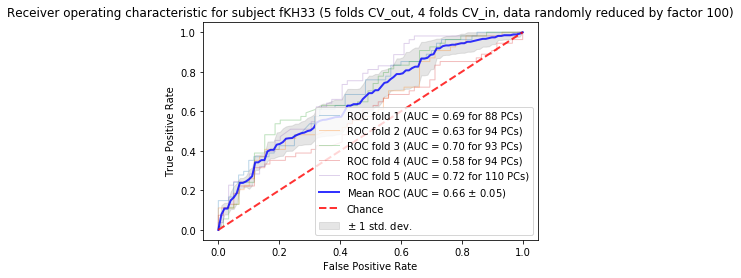

In [9]:
"""Split data into training and testing sets"""

# parameters:
n_splits_o = n_splits_o
n_splits_i = n_splits_i
nb_features_tot = animal_features.shape[1]

cv_o = StratifiedKFold(n_splits=n_splits_o)
cv_i = StratifiedKFold(n_splits=n_splits_i)


AUC_i = np.zeros((n_splits_o, n_splits_i, nb_features_tot))
AUC_means = np.zeros((n_splits_o, nb_features_tot))
# Acc_train_i = np.zeros((n_splits_o, n_splits_i))
# Acc_val_i = np.zeros((n_splits_o, n_splits_i))
Best_features = np.zeros(n_splits_o)
Best_features_valAUC = np.zeros(n_splits_o)
AUC_o = np.zeros(n_splits_o)

tprs = []
mean_fpr = np.linspace(0, 1, 100)


"""Outer loop"""
k_out = 0
for train_o, test in cv_o.split(animal_features, animal_labels):
    data_train_o = animal_features[train_o]
    data_test = animal_features[test]
    labels_train_o = animal_labels[train_o]
    labels_test = animal_labels[test]
    
    """Inner Loop"""
    k_in = 0
    for train_i, val in cv_i.split(data_train_o, labels_train_o):

        data_train_i = animal_features[train_i]
        data_val = animal_features[val]
        labels_train_i = animal_labels[train_i]
        labels_val = animal_labels[val]

        """Hyperparameter evaluation: Number of features to keep after PCA"""
        for k_feat in range(nb_feats_min, nb_feats_max+1):
            features_kept = k_feat + 1 

            clf = make_pipeline(StandardScaler(), PCA(n_components=features_kept), svm.SVC(kernel='rbf', gamma='scale', probability=True))
            y_score = clf.fit(data_train_i, labels_train_i)

            y_predict = clf.predict_proba(data_val)
            y_predict_train = clf.predict(data_train_i)

#             Acc_val_i[k_out, k_in] = metrics.accuracy_score(labels_val, y_predict)
#             Acc_train_i[k_out, k_in] = metrics.accuracy_score(labels_train_i, y_predict_train)
            fpr, tpr, thresholds = roc_curve(labels_val, y_predict[:, 1])
            AUC_i[k_out, k_in, k_feat] = auc(fpr, tpr)
        
        print('Process ended, outer fold ', k_out, ', inner fold ', k_in)
        k_in += 1
        
    AUC_means = np.mean(AUC_i, axis=1)
    
    """Choice of the best performing Hyperparameters:"""
    Best_features[k_out] = int(np.argmax(AUC_means[k_out,:]) + 1)
    Best_features_valAUC[k_out] = np.max(AUC_means[k_out,:])
    
    """Performance on the test set"""
    clf = make_pipeline(StandardScaler(), PCA(n_components=int(Best_features[k_out])), svm.SVC(kernel='rbf', gamma='scale', probability=True))
    y_score = clf.fit(data_train_o, labels_train_o)
    
    y_predict = clf.predict_proba(data_test)
    y_predict_train = clf.predict(data_train_o)
    
    """ROC curve"""
    fpr, tpr, thresholds = roc_curve(labels_test, y_predict[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    AUC_o[k_out] = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f for %d PCs)' % (k_out+1, AUC_o[k_out], int(Best_features[k_out])))  
    
    print('Process ended, outer fold ', k_out)
    k_out += 1

"""mean ROC curve"""             
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(AUC_o)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')       
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for subject %s (%d folds CV_out, %d folds CV_in, data randomly reduced by factor %d)' % (animal_names[animal_ID], n_splits_o, n_splits_i, factor_red))
plt.legend(loc="lower right")
plt.savefig('ROC_' + animal_names[animal_ID] + '.png')  
plt.show()             
           
             
             


In [ ]:
print(AUC_i)
print(AUC_o)
print(Best_features)
print(Best_features_valAUC)

In [ ]:
print(AUC_i)

In [24]:
print(AUC_i[1,1,1])

0.0


In [25]:
print(AUC_o)

[0.71034237 0.68750595 0.70170427 0.67919768 0.68258879]


In [114]:
np.unique(animal_labels)

array([0, 1], dtype=uint8)

In [116]:
list(animal_labels).count(0)

1434

In [1]:
print(y_predict)

NameError: name 'y_predict' is not defined